# Análisis Pancho

## 1) Importar librerías, importar datos, cambio tipo de dato variable "CodVendedor" y "ItemCode", ver dimensiones del df y tipología de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts.models.forecasting import fft
from darts.models.forecasting.arima import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

C:\Users\silva\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\silva\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
df = pd.read_excel("SalesFact.xlsx").drop(columns = ['Cantidad (en UM de inventario)', 'Código de almacén de línea', 'CanalDeVenta'])
df['Número de documento'] = df['Número de documento'].astype('object')
df.CodVendedor = df.CodVendedor.astype('object')
df.ItemCode = df.ItemCode.astype('object')
df.head()

,VentaNeta,CodCliente,Número de documento,ItemCode,CodVendedor,Fecha,Descripción del artículo,Kilombos
0,82530.0,C9233798,1017811,100401409101,95,2019-04-01,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,10.0
1,254117.0,C76658352,1017839,140202409101,4,2019-04-02,Cranberry Cubierta Chocolate Leche Bl. 5Kg,40.0
2,30252.0,C13479118,1018354,260502409101,4,2019-04-05,Mani Cubierta Chocolate Leche Bl. 5Kg,5.0
3,35294.0,C13479118,1018354,140202409101,4,2019-04-05,Cranberry Cubierta Chocolate Leche Bl. 5Kg,5.0
4,40757.0,C13479118,1018354,100402409101,4,2019-04-05,Almendras Cubiertas Con Chocolate De Leche Bl ...,5.0


In [3]:
df.shape

(6698, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6698 entries, 0 to 6697
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   VentaNeta                 5929 non-null   float64       
 1   CodCliente                5929 non-null   object        
 2   Número de documento       6698 non-null   object        
 3   ItemCode                  6698 non-null   object        
 4   CodVendedor               6698 non-null   object        
 5   Fecha                     6698 non-null   datetime64[ns]
 6   Descripción del artículo  6698 non-null   object        
 7   Kilombos                  6698 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 418.8+ KB


## 2) Crear variables:

- Materia Prima: Si es Almendra, Cranberry o Maní
- Chocolate: Si es envuelto en chocolate Leche o Bitter
- Formato: Qué tipo de formato de venta fue (5 kilos o 200g)

In [5]:
df['Descripción del artículo'].unique()

array(['Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.',
       'Cranberry Cubierta Chocolate Leche Bl. 5Kg',
       'Mani Cubierta Chocolate Leche Bl. 5Kg',
       'Almendras Cubiertas Con Chocolate De Leche Bl 5 Kg',
       'Mani Cubierta Chocolate Bitter Bl. 5Kg',
       'Cranberry Entero  Cubierta Chocolate Bitter Bl. 5Kg',
       'Almendras Cubiertas Con Chocolate De Leche Bl 1 Kg',
       'Almendra Cubierta Con Chocolate Bitter Bl 200Gr.',
       'Mani Cubierta Chocolate Leche Bl. 200Gr.',
       'Mani Cubierta Chocolate Bitter Bl. 200Gr.',
       'Cranberry Cubierta Chocolate Leche Bl. 200 Gr.',
       'Almendra Cubierta Con Chocolate De Leche Bl 200Gr.',
       'Cranberry Entero  Cubierta Chocolate Bitter Bl.200 Gr.',
       'Mani Cubierta Chocolate Leche Bl. 1Kg.',
       'Almendra Cubiertas Con Chocolate Bitter Bl 1 Kg.',
       'Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg'],
      dtype=object)

In [6]:
df['MateriaPrima'] = np.where(df['Descripción del artículo'].str.find("Mani")>=0,"Maní",
                     np.where(df['Descripción del artículo'].str.find("Almendra")>=0,"Almendra",
                     np.where(df['Descripción del artículo'].str.find("Cranberry")>=0,"Cranberry","Otro")))

df.MateriaPrima.unique()

array(['Almendra', 'Cranberry', 'Maní'], dtype=object)

In [7]:
df['Chocolate'] = np.where(df['Descripción del artículo'].str.find("Bitter")>=0,"Bitter",
            np.where(df['Descripción del artículo'].str.find("Leche")>=0,"Leche","Otro"))
df.MateriaPrima.unique()

array(['Almendra', 'Cranberry', 'Maní'], dtype=object)

In [8]:
df['Formato'] = np.where(df['Descripción del artículo'].str.find("200 Gr")+df['Descripción del artículo'].str.find("200Gr")>=0,"200 Gr",
                np.where(df['Descripción del artículo'].str.find("1 Kg")+df['Descripción del artículo'].str.find("1Kg")>=0,"1000 Gr",
                np.where(df['Descripción del artículo'].str.find("5 Kg")+df['Descripción del artículo'].str.find("5Kg")>=0,"5000 Gr","Otro")))
df.Formato.unique()

array(['5000 Gr', '1000 Gr', '200 Gr'], dtype=object)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6698 entries, 0 to 6697
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   VentaNeta                 5929 non-null   float64       
 1   CodCliente                5929 non-null   object        
 2   Número de documento       6698 non-null   object        
 3   ItemCode                  6698 non-null   object        
 4   CodVendedor               6698 non-null   object        
 5   Fecha                     6698 non-null   datetime64[ns]
 6   Descripción del artículo  6698 non-null   object        
 7   Kilombos                  6698 non-null   float64       
 8   MateriaPrima              6698 non-null   object        
 9   Chocolate                 6698 non-null   object        
 10  Formato                   6698 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 575.7+ KB


In [10]:
df.head()

,VentaNeta,CodCliente,Número de documento,ItemCode,CodVendedor,Fecha,Descripción del artículo,Kilombos,MateriaPrima,Chocolate,Formato
0,82530.0,C9233798,1017811,100401409101,95,2019-04-01,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,10.0,Almendra,Bitter,5000 Gr
1,254117.0,C76658352,1017839,140202409101,4,2019-04-02,Cranberry Cubierta Chocolate Leche Bl. 5Kg,40.0,Cranberry,Leche,5000 Gr
2,30252.0,C13479118,1018354,260502409101,4,2019-04-05,Mani Cubierta Chocolate Leche Bl. 5Kg,5.0,Maní,Leche,5000 Gr
3,35294.0,C13479118,1018354,140202409101,4,2019-04-05,Cranberry Cubierta Chocolate Leche Bl. 5Kg,5.0,Cranberry,Leche,5000 Gr
4,40757.0,C13479118,1018354,100402409101,4,2019-04-05,Almendras Cubiertas Con Chocolate De Leche Bl ...,5.0,Almendra,Leche,5000 Gr


In [11]:
df.groupby(['MateriaPrima', 'Chocolate', 'Formato'])['Kilombos'].agg(['sum', 'count'])

sum  count
MateriaPrima Chocolate Formato                
Almendra     Bitter    1000 Gr      1.0      1
                       200 Gr     665.6    113
                       5000 Gr  10500.0   1196
             Leche     1000 Gr      1.0      1
                       200 Gr     598.2     91
                       5000 Gr   8300.0    844
Cranberry    Bitter    1000 Gr      1.0      1
                       200 Gr     884.8    119
                       5000 Gr  14310.0   1481
             Leche     200 Gr     497.4     83
                       5000 Gr   8195.0    743
Maní         Bitter    200 Gr     676.0     94
                       5000 Gr   8335.0    991
             Leche     1000 Gr      1.0      1
                       200 Gr     758.8     97
                       5000 Gr   8550.0    842

In [12]:
df = df[df.Formato != '1000 Gr']
df['MateriaPrimaChocolate'] = df['MateriaPrima']+ " - "+df['Chocolate']


## 3) Limpieza de datos

1.  Dejamos sólo las variables 'Fecha' y 'Kilos' (Cambiando de nombre la variable 'kilombos')
2.  Creamos la variable 'Año' y 'Semana' (Con semana empezando por día lunes)
3.  Creamos la variable 'Año-Semana'
4.  Dejamos solo la data desde 2019-04-15 en adelante (ya que hay semanas hacia atrás de esto que tienen ventas 0, impidiendo modelos asumiendo aditividad)
5.  Dejamos sólo semanas completas, para obtener las 138 semanas de dataset y predecir las últimas 12 (3 meses) | 
6.  Sacamos los Outliers por 3 Desvest

## Pasos 1,2,3,4,5,6

In [13]:
df = df[['Fecha', 'Kilombos']].rename(columns={'Kilombos':'Kilos'})
df['Año'] = df['Fecha'].dt.year
df['Semana'] = np.where(df['Fecha'].dt.isocalendar().week<10, str(0) + df['Fecha'].dt.isocalendar().week.astype('str'), df['Fecha'].dt.isocalendar().week.astype('object'))
df['Año-Semana'] = df['Año'].astype('str') + '-' + df['Semana'].astype('str')
df['Año-Semana'] = df['Año-Semana'].replace({'2019-01':'2020-01'})
df = df[df['Fecha'] > '2019-04-15']
df = df.sort_values(by = 'Año-Semana', ascending = True)
df.head()


,Fecha,Kilos,Año,Semana,Año-Semana
5,2019-04-25,5.0,2019,17,2019-17
6,2019-04-25,5.0,2019,17,2019-17
7,2019-04-25,5.0,2019,17,2019-17
8,2019-04-25,5.0,2019,17,2019-17
16,2019-05-03,10.0,2019,18,2019-18


In [14]:
len(df['Año-Semana'].unique())

150

## Paso 6) Sacamos los Outliers por 3, 3.5, 4 y 5 Desvest (sacadas por año-semana), y luego se limpia cada registro según mean+-desvest que dió para cada año-semana

In [15]:
# Código de Benja

# Identificamos la media y desviacion estandar por semana
df_sales_weekly = pd.DataFrame()
df_sales_weekly = df.groupby(['Año-Semana']).agg({'Kilos' : ['mean', 'std']})
df_sales_weekly.columns = ['mean', 'std']
df_sales_weekly = df_sales_weekly.reset_index().fillna(0) #Se vuelve a dejar "Año-Semana" como columna. La semana 2019-25 tiene sólo 1 registro por lo que la desviación estándar da NAN

#Cruzamos con el dataframe recién guardado
df = pd.merge(df, df_sales_weekly, on ='Año-Semana', how='left')
df.head()

,Fecha,Kilos,Año,Semana,Año-Semana,mean,std
0,2019-04-25,5.0,2019,17,2019-17,5.000,0.000000
1,2019-04-25,5.0,2019,17,2019-17,5.000,0.000000
2,2019-04-25,5.0,2019,17,2019-17,5.000,0.000000
3,2019-04-25,5.0,2019,17,2019-17,5.000,0.000000
4,2019-05-03,10.0,2019,18,2019-18,3.125,5.303301


In [16]:
df.shape

(6689, 7)

(-75.0, 75.0)

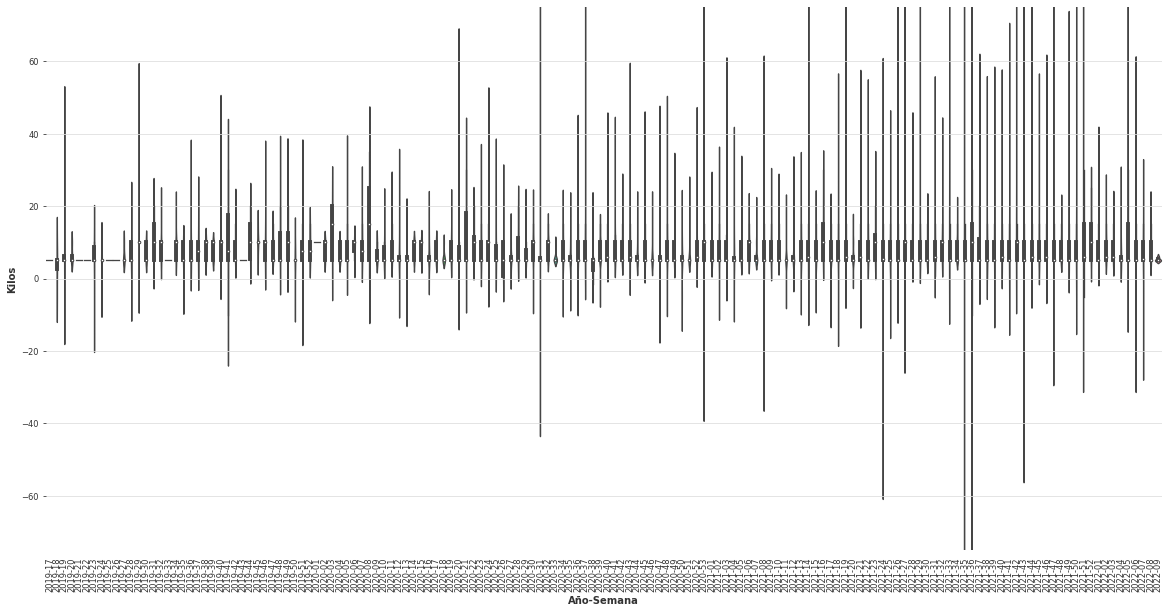

In [17]:
plt.rcParams['figure.figsize'] =(20,10)
sns.violinplot(data = df, x='Año-Semana', y='Kilos')
plt.xticks(rotation=90)
plt.ylim(-75,75)

(-40.0, 40.0)

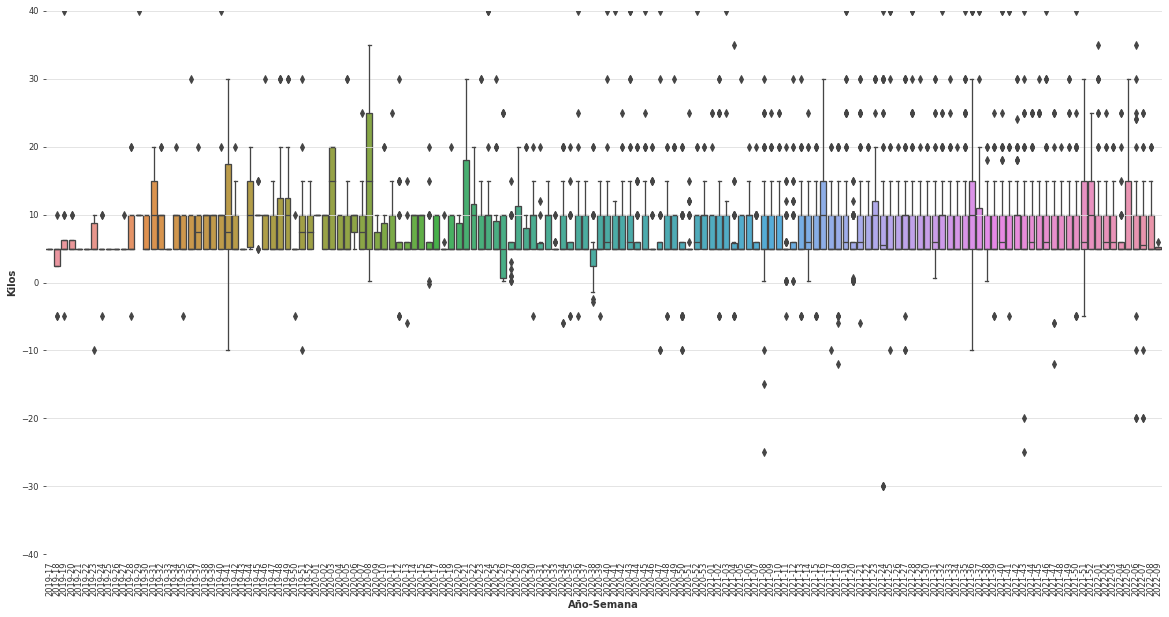

In [18]:
plt.rcParams['figure.figsize'] =(20,10)
sns.boxplot(data = df, x='Año-Semana', y='Kilos', orient='v')
plt.xticks(rotation=90)
plt.ylim(-40,40)

In [19]:
#Definimos si es outlier o no en base a 3, 4 y 5 desviaciones estándar
df['Kilos_2DV'] = np.where((df.Kilos > (df['mean'] + 2*df['std'])) | (df.Kilos < (df['mean'] - 2*df['std'])), 1, 0)
df['Kilos_3DV'] = np.where((df.Kilos > (df['mean'] + 3*df['std'])) | (df.Kilos < (df['mean'] - 3*df['std'])), 1, 0)
df['Kilos_35DV'] = np.where((df.Kilos > (df['mean'] + 3.5*df['std'])) | (df.Kilos < (df['mean'] - 3.5*df['std'])), 1, 0)
df['Kilos_4DV'] = np.where((df.Kilos > (df['mean'] + 4*df['std'])) | (df.Kilos < (df['mean'] - 4*df['std'])), 1, 0)
df['Kilos_5DV'] = np.where((df.Kilos > (df['mean'] + 5*df['std'])) | (df.Kilos < (df['mean'] - 5*df['std'])), 1, 0)
df.head()

,Fecha,Kilos,Año,Semana,Año-Semana,mean,std,Kilos_2DV,Kilos_3DV,Kilos_35DV,Kilos_4DV,Kilos_5DV
0,2019-04-25,5.0,2019,17,2019-17,5.000,0.000000,0,0,0,0,0
1,2019-04-25,5.0,2019,17,2019-17,5.000,0.000000,0,0,0,0,0
2,2019-04-25,5.0,2019,17,2019-17,5.000,0.000000,0,0,0,0,0
3,2019-04-25,5.0,2019,17,2019-17,5.000,0.000000,0,0,0,0,0
4,2019-05-03,10.0,2019,18,2019-18,3.125,5.303301,0,0,0,0,0


In [20]:
# Mostramos la cantidad de outliers que saca por cada caso
df.sum()

Kilos                                                   62205.8
Año                                                    13516412
Año-Semana    2019-172019-172019-172019-172019-182019-182019...
mean                                                    62205.8
std                                                68540.356745
Kilos_2DV                                                   359
Kilos_3DV                                                   140
Kilos_35DV                                                   94
Kilos_4DV                                                    67
Kilos_5DV                                                    30
dtype: object

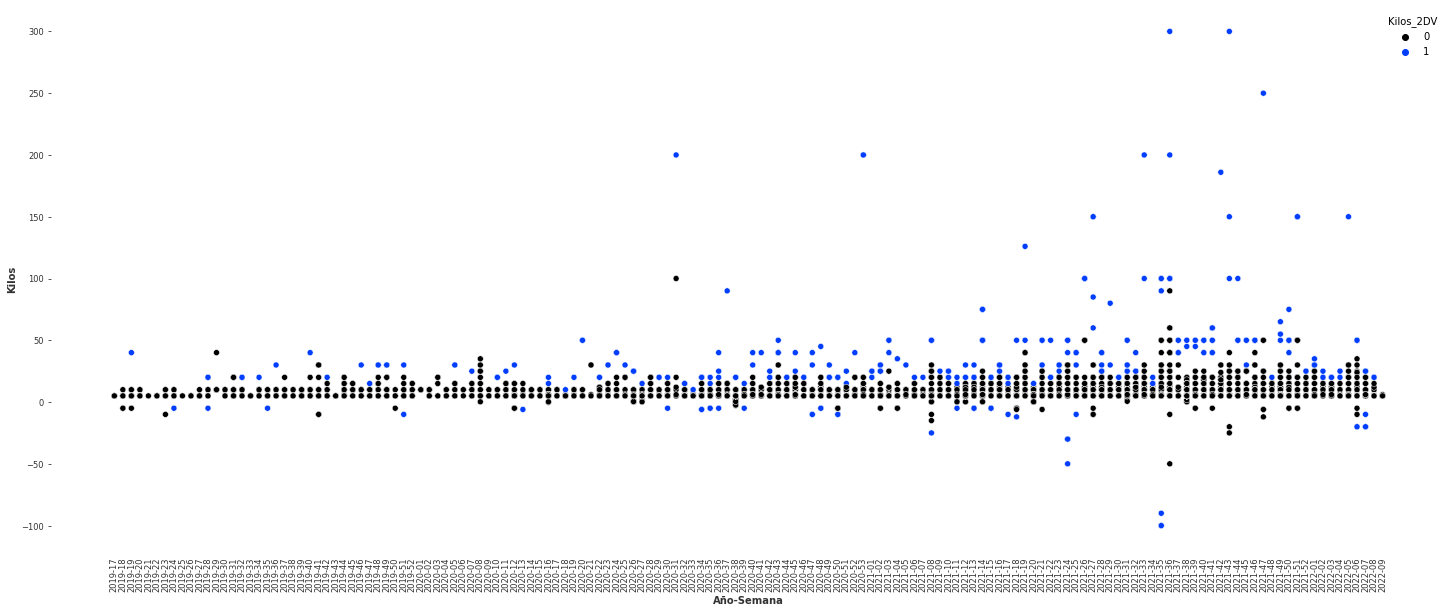

In [21]:
fig, ax = plt.subplots(figsize=(25,10))
plt.grid(False)
df = df.sort_values(by = 'Año-Semana', ascending=True)
sns.scatterplot(data=df, x = 'Año-Semana', y = 'Kilos', hue= 'Kilos_2DV', ax = ax)
plt.xticks(rotation=90);

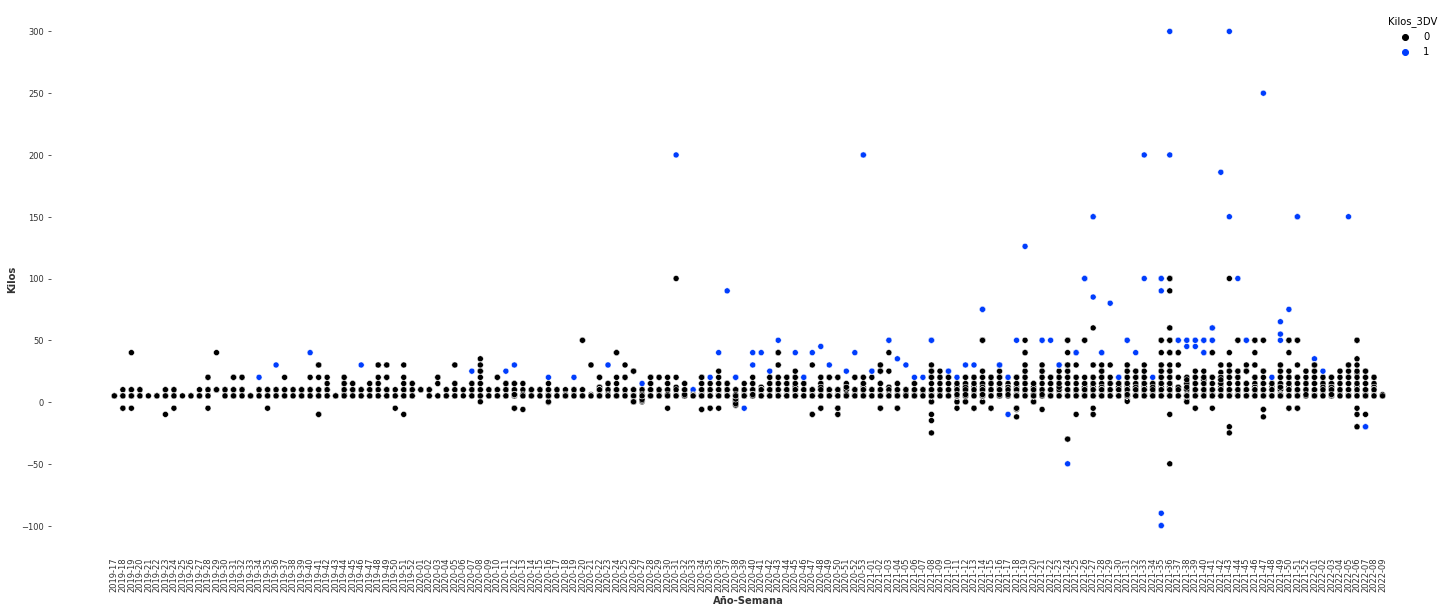

In [22]:
fig, ax = plt.subplots(figsize=(25,10))
plt.grid(False)
df = df.sort_values(by = 'Año-Semana', ascending=True)
sns.scatterplot(data=df, x = 'Año-Semana', y = 'Kilos', hue= 'Kilos_3DV', ax = ax)
plt.xticks(rotation=90);

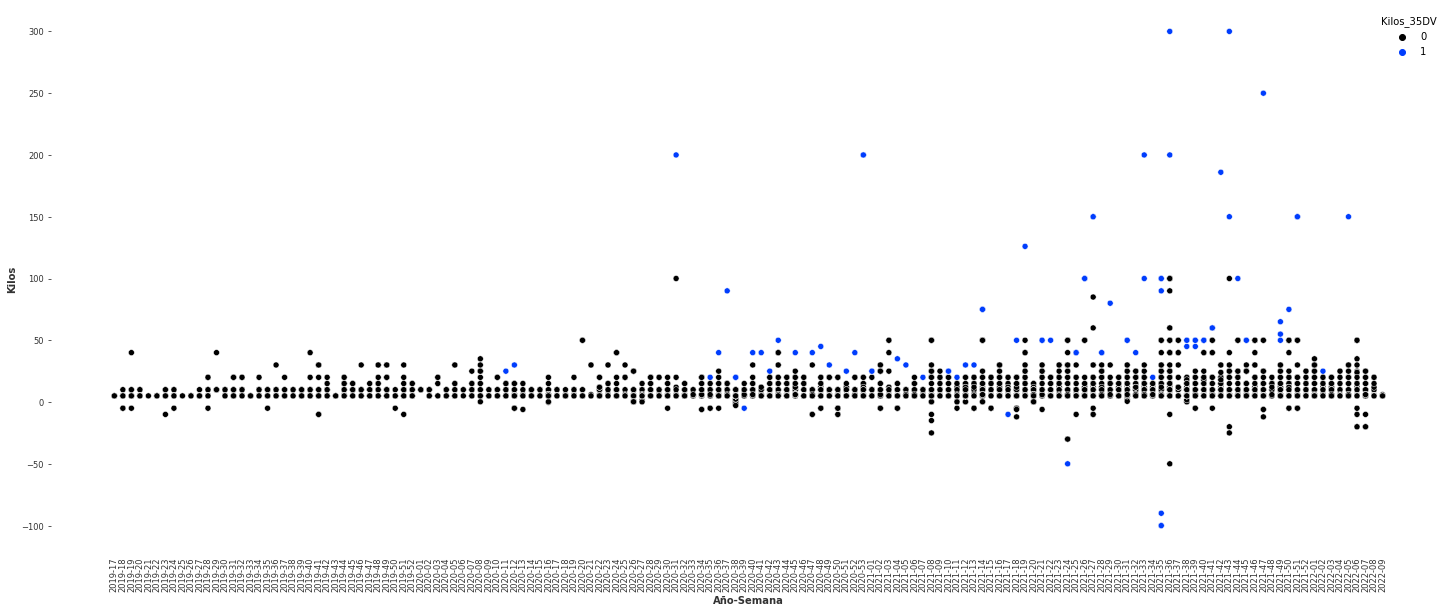

In [23]:
fig, ax = plt.subplots(figsize=(25,10))
plt.grid(False)
df = df.sort_values(by = 'Año-Semana', ascending=True)
sns.scatterplot(data=df, x = 'Año-Semana', y = 'Kilos', hue= 'Kilos_35DV', ax = ax)
plt.xticks(rotation=90);

## Generamos los dataset con cada caso, cada uno sin outliers según corresponda

In [24]:
df2dv = df[df['Kilos_2DV'] == 0][['Fecha', 'Año-Semana', 'Kilos']].set_index('Fecha').resample('W', label='left').sum().reset_index()
df3dv = df[df['Kilos_3DV'] == 0][['Fecha', 'Año-Semana', 'Kilos']].set_index('Fecha').resample('W', label='left').sum().reset_index()
df35dv = df[df['Kilos_35DV'] == 0][['Fecha', 'Año-Semana', 'Kilos']].set_index('Fecha').resample('W', label='left').sum().reset_index()
df4dv = df[df['Kilos_4DV'] == 0][['Fecha', 'Año-Semana', 'Kilos']].set_index('Fecha').resample('W', label='left').sum().reset_index()
df5dv = df[df['Kilos_5DV'] == 0][['Fecha', 'Año-Semana', 'Kilos']].set_index('Fecha').resample('W', label='left').sum().reset_index()

df35dv.head()

,Fecha,Kilos
0,2019-04-21,20.0
1,2019-04-28,25.0
2,2019-05-05,95.0
3,2019-05-12,50.0
4,2019-05-19,5.0


# 4) Modeling

In [25]:
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode

from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Prophet, Theta
from darts.metrics import mape, mae
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.datasets import TemperatureDataset

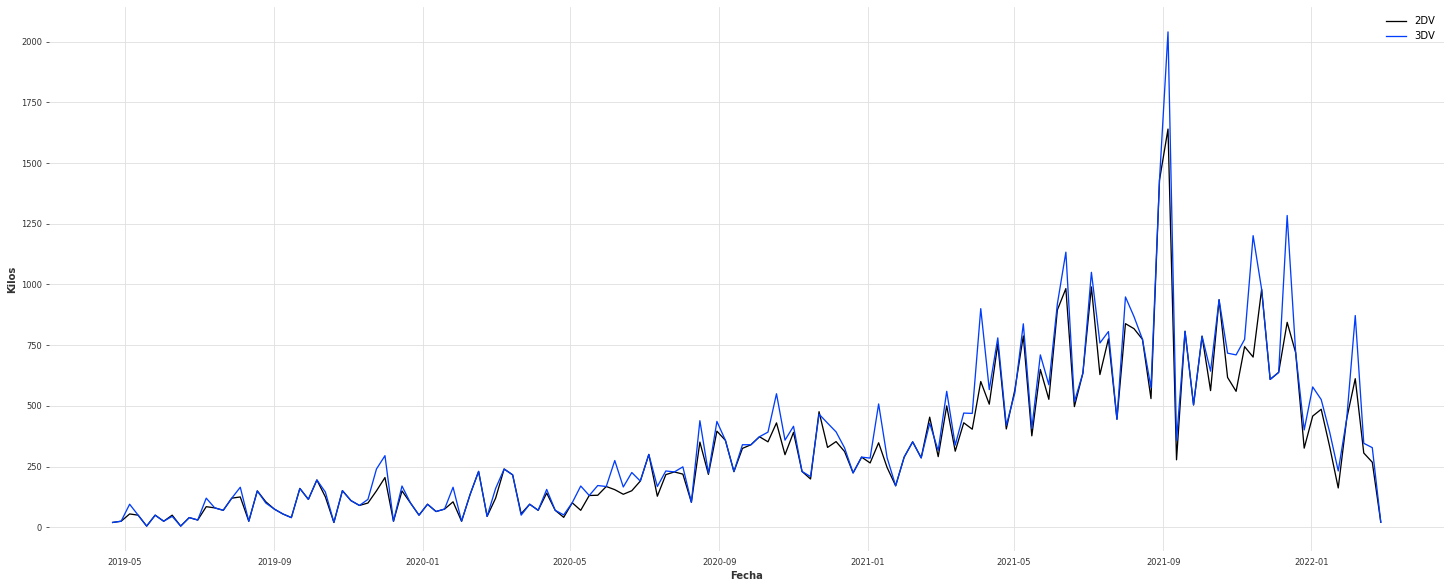

In [26]:
plt.subplots(figsize=(25,10))
sns.lineplot(data=df2dv, x="Fecha", y="Kilos", label='2DV')
#sns.lineplot(data=df3dv, x="Fecha", y="Kilos")
sns.lineplot(data=df3dv, x="Fecha", y="Kilos", label="3DV")
#sns.lineplot(data=df35dv, x="Fecha", y="Kilos", label='3.5DV')
#sns.lineplot(data=df4dv, x="Fecha", y="Kilos", label='4DV')
plt.legend()

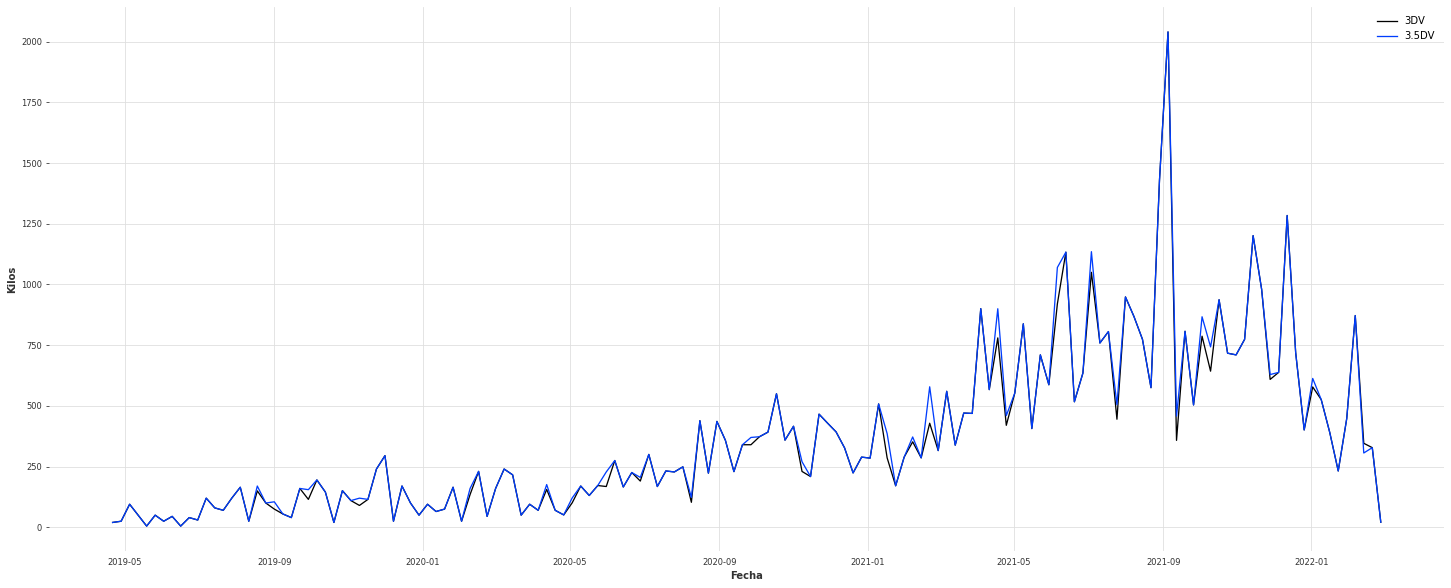

In [27]:
plt.subplots(figsize=(25,10))
#sns.lineplot(data=df2dv, x="Fecha", y="Kilos", label='2DV')
#sns.lineplot(data=df3dv, x="Fecha", y="Kilos")
sns.lineplot(data=df3dv, x="Fecha", y="Kilos", label="3DV")
sns.lineplot(data=df35dv, x="Fecha", y="Kilos", label='3.5DV')
#sns.lineplot(data=df4dv, x="Fecha", y="Kilos", label='4DV')
plt.legend()

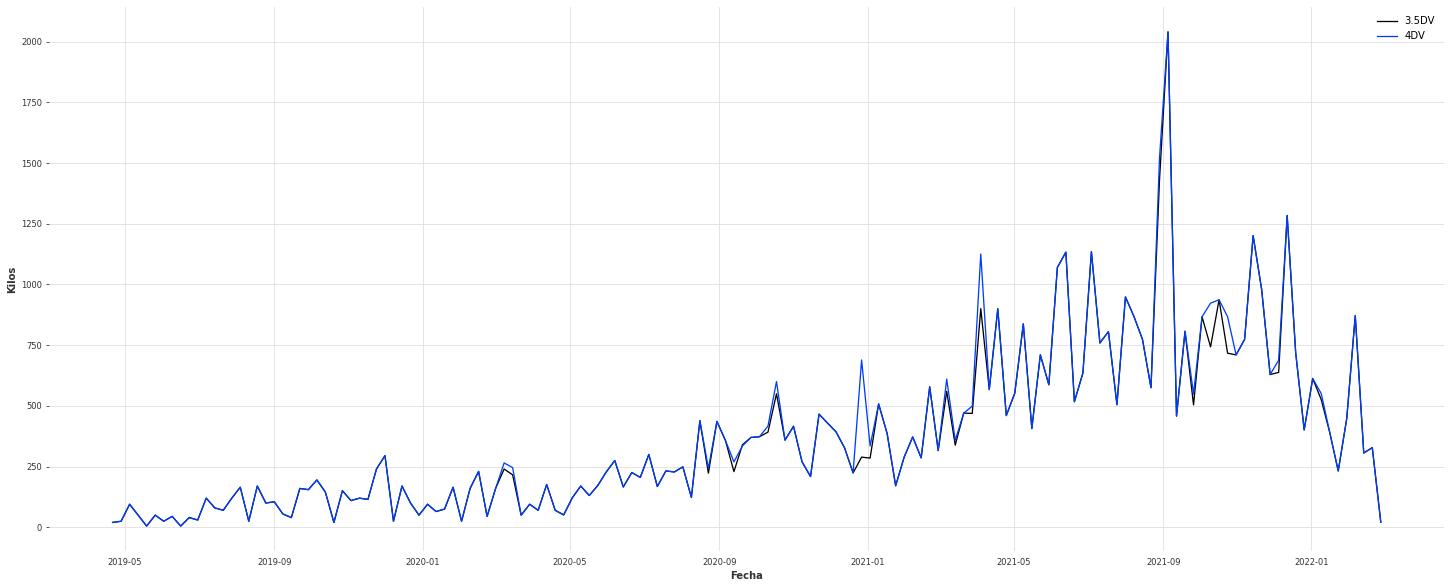

In [28]:
plt.subplots(figsize=(25,10))
#sns.lineplot(data=df2dv, x="Fecha", y="Kilos", label='2DV')
#sns.lineplot(data=df3dv, x="Fecha", y="Kilos")
#sns.lineplot(data=df3dv, x="Fecha", y="Kilos", label="3DV")
sns.lineplot(data=df35dv, x="Fecha", y="Kilos", label='3.5DV')
sns.lineplot(data=df4dv, x="Fecha", y="Kilos", label='4DV')
plt.legend()

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

additive_Tmodel = df4dv[['Kilos']]
ts_dicomposition = seasonal_decompose(x=additive_Tmodel, model='additive', period=12)
trend_estimate = ts_dicomposition.trend
seasonal_estimate = ts_dicomposition.seasonal
residual_estimate = ts_dicomposition.resid

In [30]:
residuals = {}

for i in range(1,60):
    ts_dicomposition = seasonal_decompose(x=additive_Tmodel, model='additive', period=i)
    residual_estimate = ts_dicomposition.resid
    residuals[i] = residual_estimate.mean()

pd.DataFrame.from_dict(residuals, orient='index', columns=["mean_residuals_per_periods"]).sort_values(by="mean_residuals_per_periods")

,mean_residuals_per_periods
59,-6.993824
58,-4.700327
57,-2.464297
56,-2.370647
41,-1.882768
55,-1.798744
44,-1.267777
46,-1.218226
10,-1.039643
9,-0.912788


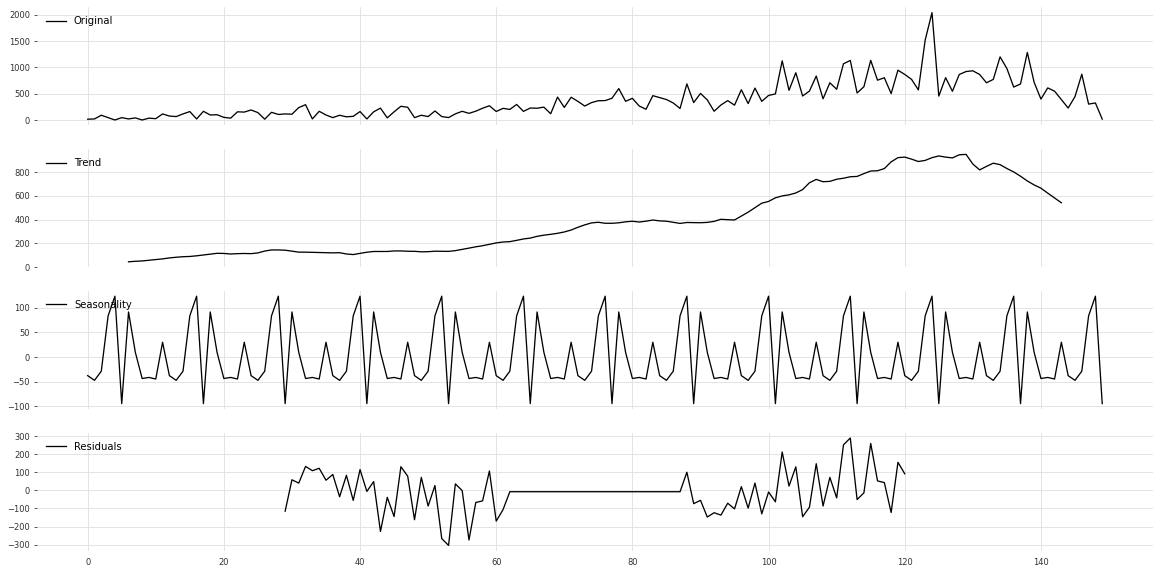

In [31]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(additive_Tmodel, label='Original')
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left');

## ARIMA 1

In [32]:
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools

import warnings
warnings.filterwarnings("ignore")

In [33]:
df4dv.set_index('Fecha').head()

,Kilos
Fecha,
2019-04-21,20.0
2019-04-28,25.0
2019-05-05,95.0
2019-05-12,50.0
2019-05-19,5.0


In [34]:
ts = df4dv.set_index('Fecha').resample('W').sum()
ts.head()

,Kilos
Fecha,
2019-04-21,20.0
2019-04-28,25.0
2019-05-05,95.0
2019-05-12,50.0
2019-05-19,5.0


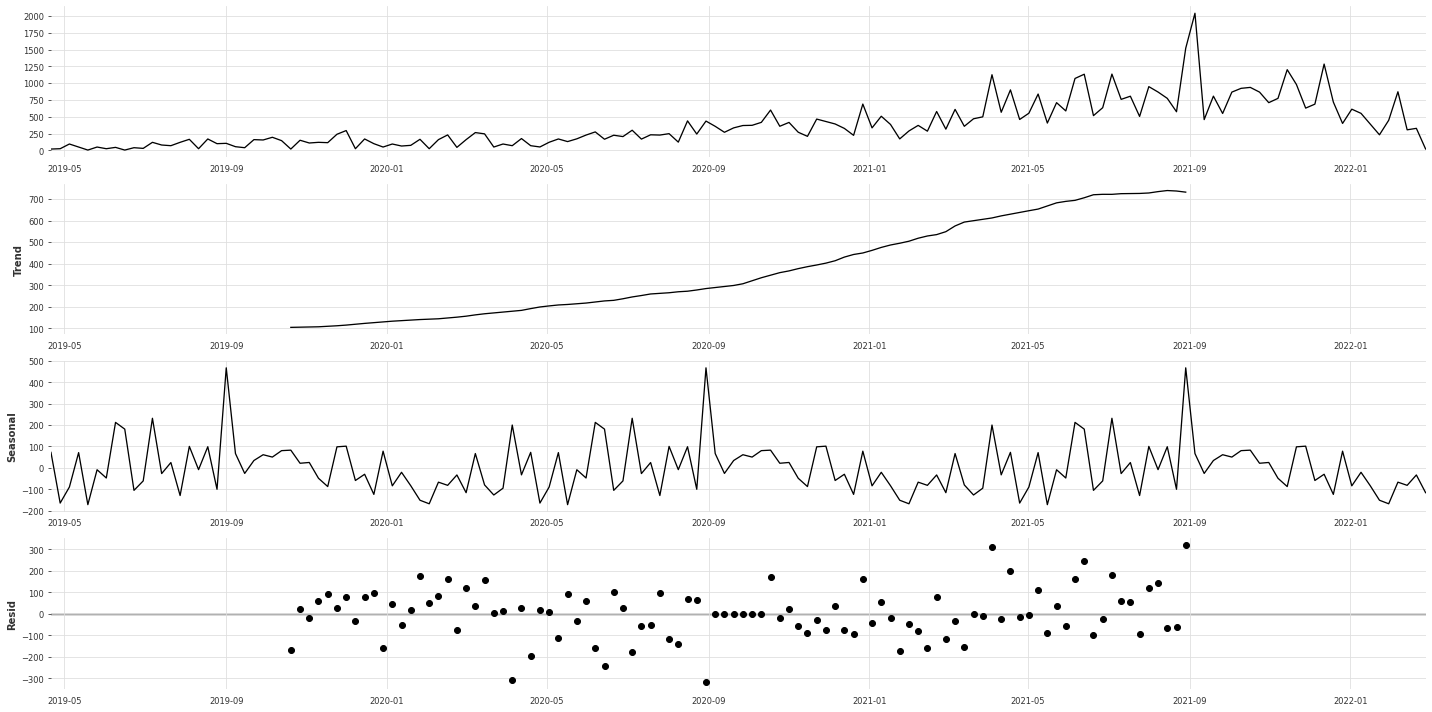

In [35]:
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
plt.rcParams["figure.figsize"] = (20,10)
decomposition.plot()
plt.show()

In [36]:
adftest = adfuller(ts)
print(f"pvalue de adfuller es: {adftest[1]}")

pvalue de adfuller es: 0.4987820819889789


In [37]:
print(f"Largo de la serie es: {len(ts)}, y el 0.8*LargoSerie es {0.8*len(ts)}")
train, test = ts[:110], ts[110:]
print(f"Largo de TRAIN: {len(train)}. Largo de TEST: {len(test)}")

Largo de la serie es: 150, y el 0.8*LargoSerie es 120.0
Largo de TRAIN: 110. Largo de TEST: 40


In [38]:
test.head()

,Kilos
Fecha,
2021-05-30,587.0
2021-06-06,1070.0
2021-06-13,1133.0
2021-06-20,517.0
2021-06-27,635.0


In [39]:
p = range(0,52) # range(0,4) en mensual
d = range(1,2) # range(0,2 en mensual
q = range(0,1) # range(0,4) en mensual


pdq = list(itertools.product(p,d,q))
print(len(pdq))
print(pdq)

52
[(0, 1, 0), (1, 1, 0), (2, 1, 0), (3, 1, 0), (4, 1, 0), (5, 1, 0), (6, 1, 0), (7, 1, 0), (8, 1, 0), (9, 1, 0), (10, 1, 0), (11, 1, 0), (12, 1, 0), (13, 1, 0), (14, 1, 0), (15, 1, 0), (16, 1, 0), (17, 1, 0), (18, 1, 0), (19, 1, 0), (20, 1, 0), (21, 1, 0), (22, 1, 0), (23, 1, 0), (24, 1, 0), (25, 1, 0), (26, 1, 0), (27, 1, 0), (28, 1, 0), (29, 1, 0), (30, 1, 0), (31, 1, 0), (32, 1, 0), (33, 1, 0), (34, 1, 0), (35, 1, 0), (36, 1, 0), (37, 1, 0), (38, 1, 0), (39, 1, 0), (40, 1, 0), (41, 1, 0), (42, 1, 0), (43, 1, 0), (44, 1, 0), (45, 1, 0), (46, 1, 0), (47, 1, 0), (48, 1, 0), (49, 1, 0), (50, 1, 0), (51, 1, 0)]


In [40]:
diccionarioo = {}

for i in range(0,23):
        model=sm.tsa.statespace.SARIMAX(train, order = (i,1,0), seasonal_order= (0,0,0,12) ).fit()
        pred=model.predict(start=len(train), end=(len(ts)-1))
        error=mean_absolute_percentage_error(test, pred)
        print(str(i), error)
        diccionarioo[str(i)]=error

results = pd.DataFrame.from_dict(diccionarioo, orient='index', columns=["mape"]).sort_values(by="mape")
results

0 1.191392947696756
1 1.0272915952401316
2 1.0424339536461376
3 1.0476170098677724
4 1.0279023637940936
5 1.0420766938365662
6 1.0360451773434598
7 1.0753151050047072
8 1.071664998096916
9 1.0752461523617611
10 1.054900490804481
11 1.0326332546769197
12 1.0317320410594955
13 1.0163231501432346
14 1.0257883650051933
15 1.0417310807114317
16 1.078591656419046
17 1.1051318262027499
18 1.0324792667470881
19 1.1926426994557422
20 1.3350533836907292
21 1.396634981506116
22 1.3144589560666977


,mape
13,1.016323
14,1.025788
1,1.027292
4,1.027902
12,1.031732
18,1.032479
11,1.032633
6,1.036045
15,1.041731
5,1.042077


In [41]:
model_final=sm.tsa.statespace.SARIMAX(train, order = (22,0,0), seasonal_order= (0,0,0,12) ).fit()
prediccion=model_final.predict(start=len(train), end=(len(ts)-1))

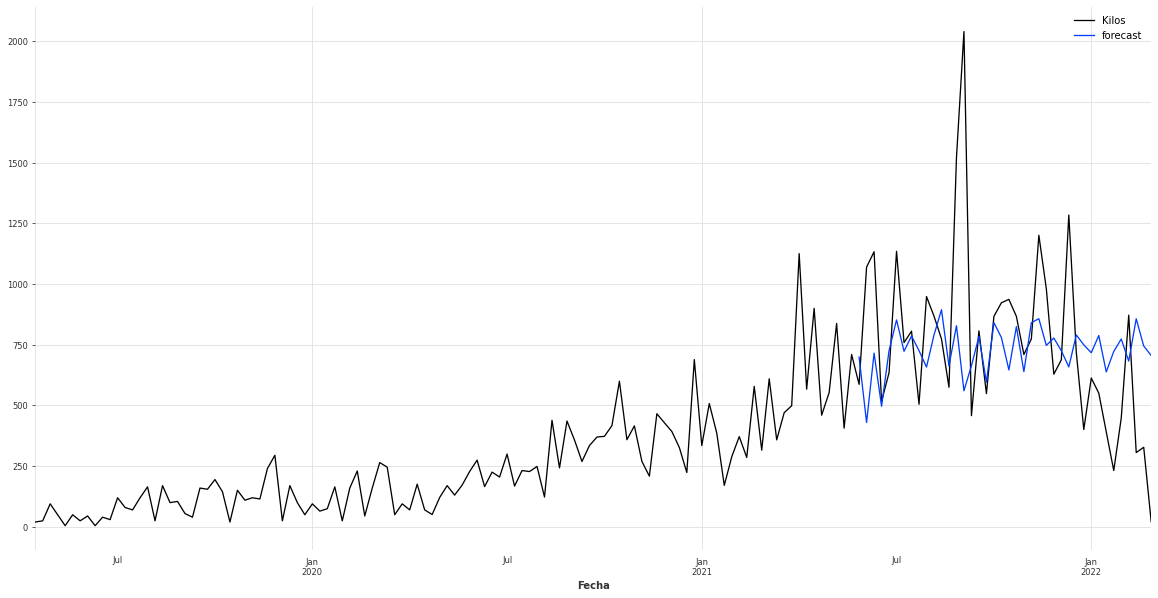

In [42]:
ts.plot(label='original', figsize=(20,10))
prediccion.plot(label='forecast')
plt.legend()

## PACF

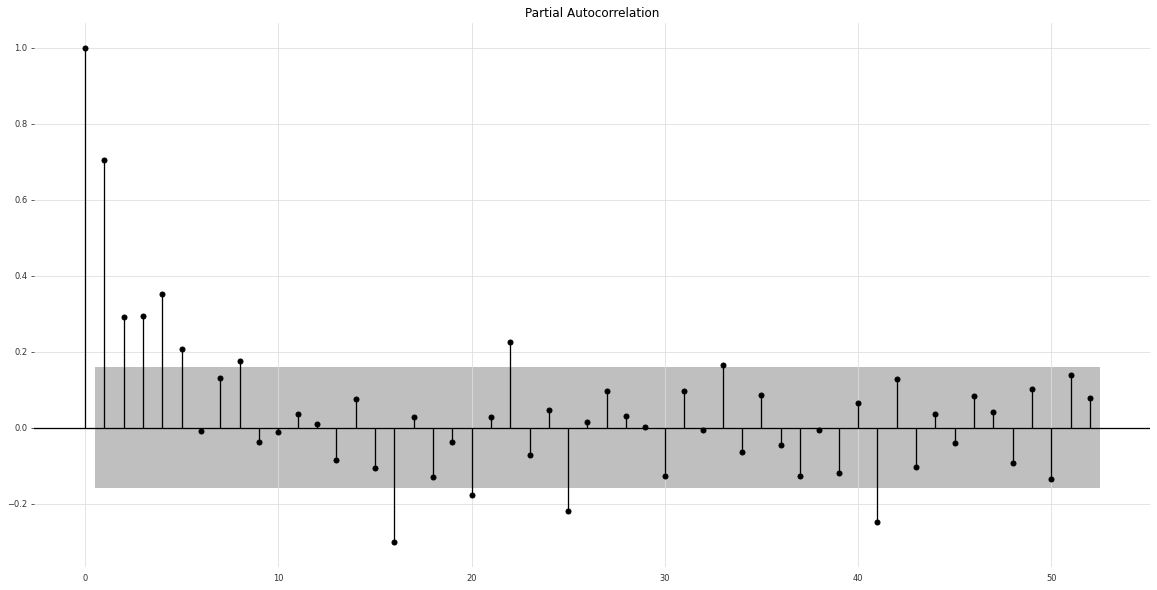

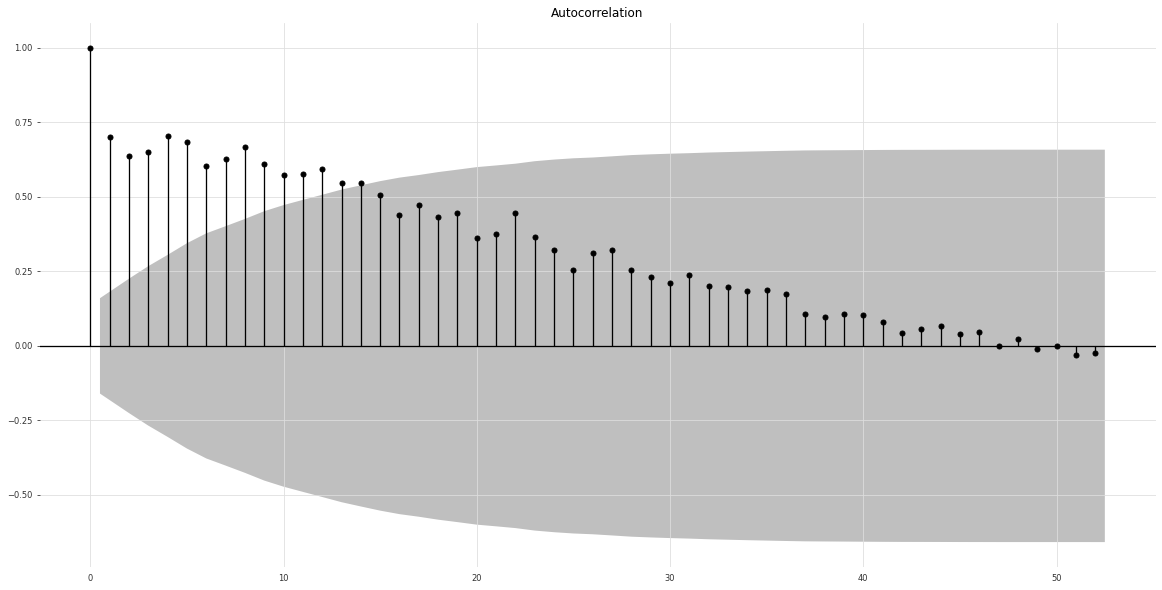

In [43]:
plot_pacf(ts, lags=52);
plot_acf(ts, lags=52);

## FFT

In [44]:
from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Prophet, Theta
from darts.metrics import mape, mae
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.datasets import TemperatureDataset

ts = df4dv.set_index('Fecha')
ts.head()

,Kilos
Fecha,
2019-04-21,20.0
2019-04-28,25.0
2019-05-05,95.0
2019-05-12,50.0
2019-05-19,5.0


In [45]:
temperature = TemperatureDataset().load()
temperature

<TimeSeries (DataArray) (Date: 3652, component: 1, sample: 1)>
array([[[20.7]],

       [[17.9]],

       [[18.8]],

       ...,

       [[13.5]],

       [[15.7]],

       [[13. ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1981-01-01 1981-01-02 ... 1990-12-31
  * component  (component) object 'Daily minimum temperatures'
Dimensions without coordinates: sample

In [46]:
type(temperature)

darts.timeseries.TimeSeries

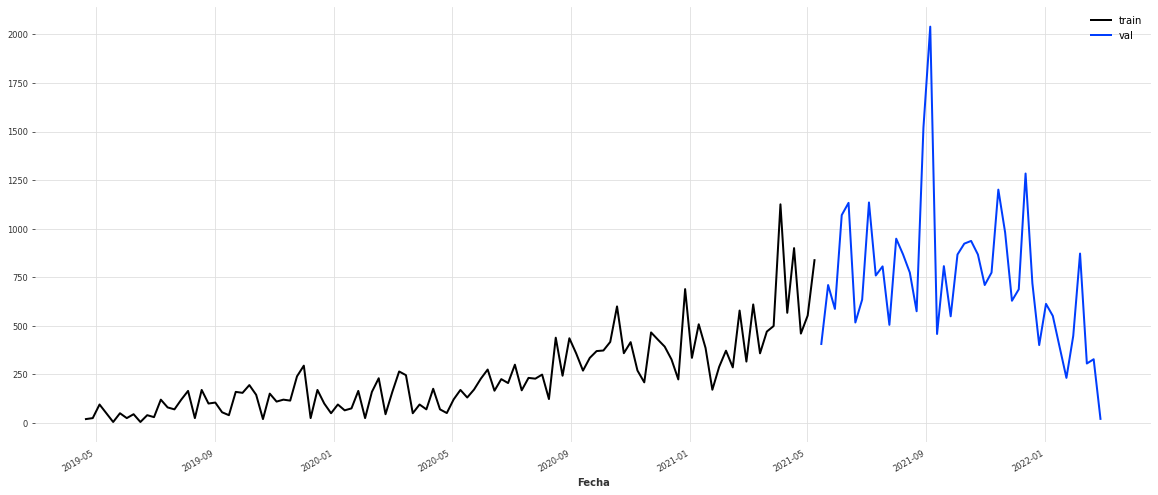

In [47]:
ts = TimeSeries.from_dataframe(df4dv, 'Fecha', 'Kilos')
ts = fill_missing_values(ts, "auto")

plt.subplots(1, 1,figsize=(20,8))
train, val = ts.split_after(pd.Timestamp("20210509"))
train.plot(label="train")
val.plot(label="val")

MAPE: 45.098318508199775
MAE: 616.4494062126216


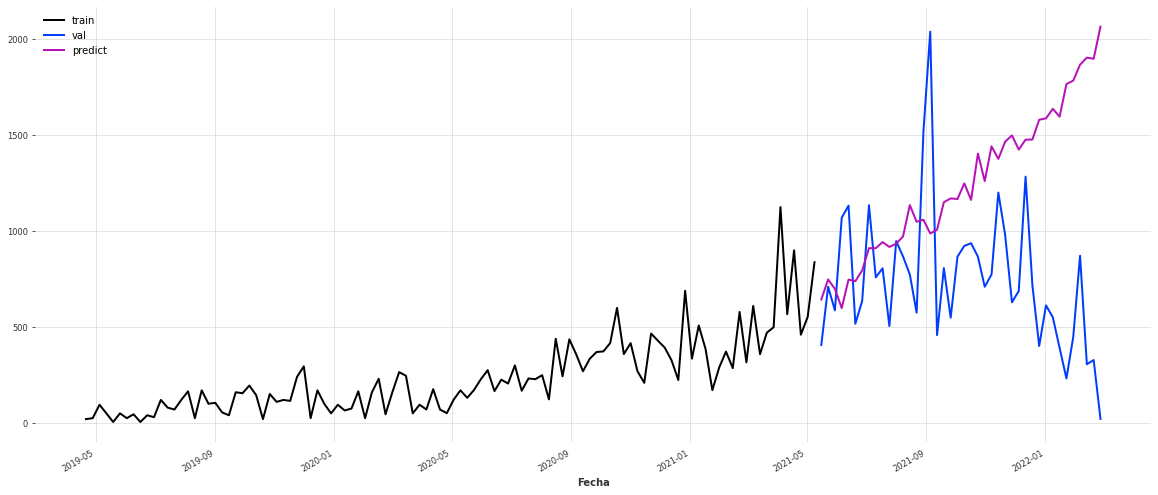

In [48]:
plt.subplots(1, 1,figsize=(20,8))

model = FFT(required_matches={'week'}, trend='exp', nr_freqs_to_keep=26)
model.fit(train)
pred_val = model.predict(len(val))

train.plot(label="train" )
val.plot(label="val")
pred_val.plot(label="predict")
print("MAPE:", mape(pred_val, val))
print("MAE:", mae(pred_val, val))

In [52]:
val.pd_dataframe().sum() - pred_val.pd_dataframe().sum()

component
Kilos   -20554.541864
dtype: float64

In [49]:
residuals4 = {}

ts = TimeSeries.from_dataframe(df4dv, 'Fecha', 'Kilos')
ts = fill_missing_values(ts, "auto")

train, val = ts.split_after(pd.Timestamp("20210509"))

for i in range(2,52):
    model = FFT(required_matches={'week'}, trend='exp', nr_freqs_to_keep=i)
    model.fit(train)
    pred_val = model.predict(len(val))
    residuals4[i] = mape(pred_val, val)

pd.DataFrame.from_dict(residuals4, orient='index', columns=["mape"]).sort_values(by="mape")

,mape
3,43.509413
2,43.521350
7,43.650788
4,43.711424
6,43.759708
8,43.829142
5,43.961964
9,44.027048
10,44.083212
11,44.191008
